In [1]:
import math
import os
import json

import torch
from torch import nn, optim
import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm

from typing import List, Dict

In [2]:
from src.env import PuzzleEnv
from src.visualization.plotting import imshow_cube

In [3]:
device = "cpu"

For DQN we'll use a simple FFN similar to dist_predictor


In [4]:
class DQN(nn.Module):
    def __init__(self, inp: int, oup: int, units: List[int]):
        # TODO: we can optionally add normalization layers
        super().__init__()
        layers = []
        prev = inp
        for num_units in units:
            layers.append(nn.Linear(prev, num_units))
            layers.append(nn.ReLU())
            prev = num_units

        layers.append(nn.Linear(units[-1], oup))

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)


DQN(inp=12, oup=24, units=[128, 128])

DQN(
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=24, bias=True)
  )
)

In [5]:
class Agent:
    def __init__(self, config):
        self._load(config)

        self.config = config

    def _load(self, config):
        self.batch_size = config["batch_size"]
        self.gamma = config["gamma"]
        self.tau = config["tau"]
        self.lr = config["lr"]
        self.weight_decay = config["weight_decay"]
        self.total_steps = config["total_steps"]

        self.epsilon_start = config["epsilon_start"]
        self.epsilon_end = config["epsilon_end"]
        self.epsilon_decay = config["epsilon_decay"]
        self.steps = 0

        self.device = "cpu"

        inp, oup, network_units = (
            config["inp"],
            config["oup"],
            config["network_units"],
        )
        self.policy_network = DQN(inp, oup, network_units).to(self.device)
        self.target_network = DQN(inp, oup, network_units).to(self.device)
        self.target_network.load_state_dict(self.policy_network.state_dict())

        self.num_states, self.num_actions = inp, oup

        self.optimizer = optim.AdamW(
            self.policy_network.parameters(),
            lr=self.lr,
            amsgrad=True,
            weight_decay=self.weight_decay,
        )
        self.criterion = nn.SmoothL1Loss(reduction="none")

    def select_action(self, states, greedy=False):
        """Selects epsilon greedy action"""
        self.eps = self.epsilon_end + (
            self.epsilon_start - self.epsilon_end
        ) * math.exp(-1.0 * self.steps / self.epsilon_decay)
        eps = 0 if greedy else self.eps
        n = len(states)
        s = torch.rand(n, device=self.device)
        rand_actions = torch.randint(0, self.num_actions, (n,), device=self.device)
        with torch.no_grad():
            Q = self.policy_network(states)
            greedy_actions = torch.argmax(Q, dim=-1)

        return torch.where(s > eps, greedy_actions, rand_actions)

    def optimize(self, s, a, r, s_n, terminated, mask):
        with torch.no_grad():
            max_Q_s_n = self.target_network(s_n).max(axis=-1).values

        # mask out terminal states
        max_Q_s_n = torch.where(terminated == 1, torch.zeros_like(max_Q_s_n), max_Q_s_n)
        # r + gamma * max[Q(s', a)]
        target = r + self.gamma * max_Q_s_n

        # Q(s, a)
        Q = self.policy_network(s).gather(1, a.unsqueeze(-1))

        loss = self.criterion(Q, target.unsqueeze(-1))
        # apply mask on loss
        loss = torch.where(mask == 1, torch.zeros_like(loss), loss).mean()

        self.optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.policy_network.parameters(), 100)
        self.optimizer.step()

        return loss.item()

    def update_target_net(self) -> None:
        target_sd = self.target_network.state_dict()
        policy_sd = self.policy_network.state_dict()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        for key in policy_sd:
            target_sd[key] = policy_sd[key] * self.tau + target_sd[key] * (1 - self.tau)
        self.target_network.load_state_dict(target_sd)

In [21]:
env_config = {
    "puzzle_name": "cube_3x3x3",
    "num_envs": 128,
    "max_steps": 20,
    "reset_config": {
        "sampler": "uniform",
        "shuffle_range": [1, 8],
        "extra_generation": 4,
    },
    "reward_config": {
        "success": 10,
        "time": -0.1,
    },
    "state_repr": "color",
}

env = PuzzleEnv(env_config)

agent_config = {
    "total_steps": 1000,
    "inp": env.state_size,
    "oup": env.num_actions,
    "batch_size": env.num_envs,
    "gamma": 0.99,
    "epsilon_schedule": "exp",
    "epsilon_start": 0.9,
    "epsilon_end": 0.05,
    "epsilon_decay": 2500,
    "tau": 0.005,
    "lr": 1e-4,
    "weight_decay": 1e-5,
    "optimizer": "adam",
    "network_units": [128, 256, 128],
}

Loaded cube_3x3x3: 18 actions, 54 states


In [22]:
EPISODES = 1000
env = PuzzleEnv(env_config)
agent = Agent(agent_config)


history = {
    "reward": [],
    "avg_success": [],
    "loss": [],
    "success_per_n": {
        n: [] for n in range(*env_config["reset_config"]["shuffle_range"])
    },
    "success_length_per_n": {
        n: [] for n in range(*env_config["reset_config"]["shuffle_range"])
    },
}


def train(env, agent, episodes, history):
    s = env.reset()
    s = torch.tensor(s, device=device)
    for _ in tqdm(range(episodes)):
        for _ in range(env_config["max_steps"]):
            a = agent.select_action(s)
            s_n, r, terminated, mask = env.step(a)
            s_n = torch.tensor(s_n, device=device)

            loss = agent.optimize(s, a, r, s_n, terminated, mask)
            s = s_n
            agent.update_target_net()

        agent.steps += 1
        history["loss"].append(loss)
        history["reward"].append(
            env.get_cumulative_reward().sum().item() / env.num_envs
        )
        (
            success_rate_per_n,
            success_length_per_n,
            average_success,
        ) = env.get_completion_rate()
        history["avg_success"].append(average_success)
        for n in success_rate_per_n.keys():
            history["success_per_n"][n].append(success_rate_per_n[n])
            history["success_length_per_n"][n].append(success_length_per_n[n])

Loaded cube_3x3x3: 18 actions, 54 states


In [34]:
train(env, agent, episodes=5000, history=history)
print(sum(history["avg_success"]) / len(history["avg_success"]))
print(history["avg_success"][-1])

100%|██████████| 5000/5000 [05:30<00:00, 15.12it/s]

0.31250234382812947
0.4464285715066964


Text(0.5, 0, 'steps (thousands)')

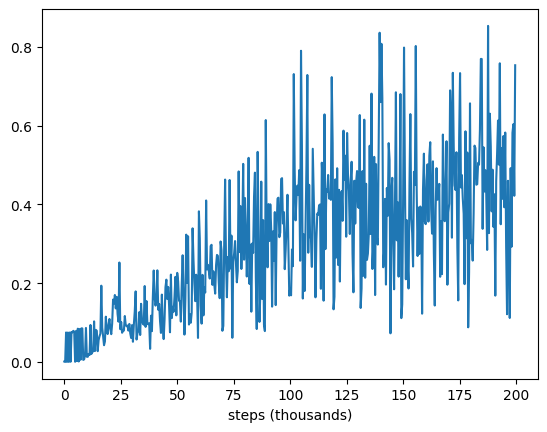

In [38]:
density = 500
gap = math.ceil(len(history["loss"]) / density)
episode_length = env_config["max_steps"]
x = [n * gap * episode_length / 1000 for n in list(range(len(history["loss"][::gap])))]
plt.plot(x, history["loss"][::gap])
plt.xlabel("steps (thousands)")

Text(0.5, 0, 'steps (thousands)')

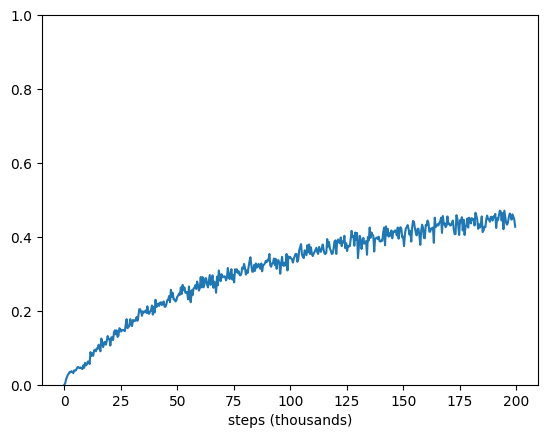

In [39]:
plt.plot(x, history["avg_success"][::gap])
plt.ylim(0, 1)
plt.xlabel("steps (thousands)")

Text(0.5, 0, 'steps (thousands)')

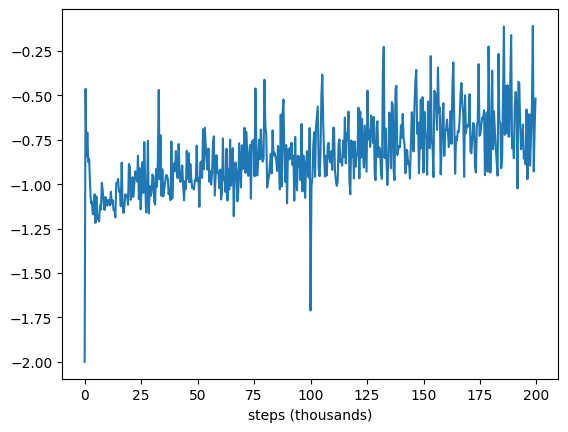

In [40]:
plt.plot(x, history["reward"][::gap])
plt.xlabel("steps (thousands)")

Text(0.5, 0, 'steps (thousands)')

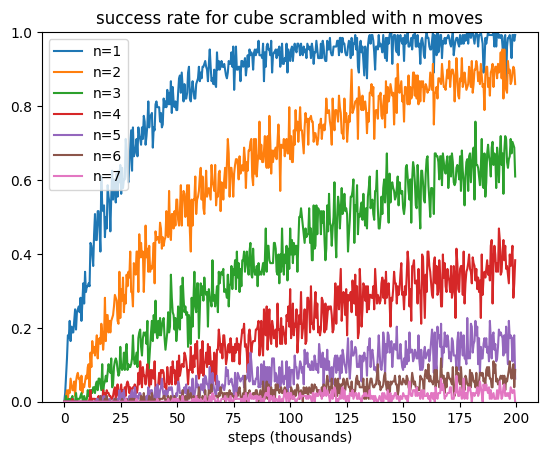

In [41]:
for n, success in history["success_per_n"].items():
    plt.plot(x, success[::gap], label=f"n={n}")


plt.title("success rate for cube scrambled with n moves")
plt.legend()
plt.ylim(0, 1)
plt.xlabel("steps (thousands)")

In [29]:
# for n, success_length in history["success_length_per_n"].items():
#     plt.plot(success_length[::gap], label=f"n={n}")


# # plt.title("Completion length per n ")
# # plt.legend()

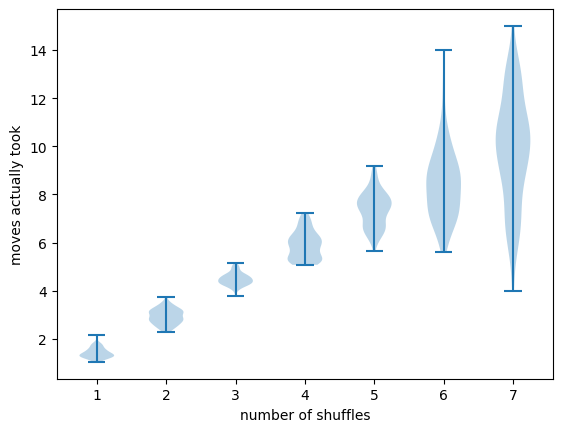

In [42]:
# take last 100 items and make a violin plot?
window = 100
# to_plot = [h[-window:] for h in history['success_length_per_n'].values()]
to_plot = [
    [n for n in h[-window:] if n != 0] for h in history["success_length_per_n"].values()
]
plt.violinplot(to_plot)
plt.ylabel("moves actually took")
plt.xlabel("number of shuffles")
plt.show()

In [ ]:
class ResultManager:
    def __init__(self, agent, env):
        self.agent: Agent = agent
        self.env: PuzzleEnv = env

        self.directory = _create_dir(self.env.config["exp_name"])

    def evaluate(self, steps):
        history = {
            "eval": True,
            "reward": [],
            "avg_success": [],
            "success_per_n": {
                n: [] for n in range(*env_config["reset_config"]["shuffle_range"])
            },
            "success_length_per_n": {
                n: [] for n in range(*env_config["reset_config"]["shuffle_range"])
            },
        }
        s = env.reset()
        s = torch.tensor(s, device=device)
        for _ in tqdm(range(steps)):
            a = agent.select_action(s, greedy=True)
            s_n, r, terminated, mask = env.step(a)
            s_n = torch.tensor(s_n, device=device)
            s = s_n
            history["reward"].append(
                env.get_cumulative_reward().sum().item() / env.num_envs
            )
            (
                success_rate_per_n,
                success_length_per_n,
                average_success,
            ) = env.get_completion_rate()
            history["avg_success"].append(average_success)
            for n in success_rate_per_n.keys():
                history["success_per_n"][n].append(success_rate_per_n[n])
                history["success_length_per_n"][n].append(success_length_per_n[n])

        return history

    def save_model(self) -> None:
        print("saving networks...")
        torch.save(
            self.agent.policy_network.state_dict(), f"{self.directory}/policy_net.pt"
        )
        torch.save(
            self.agent.target_network.state_dict(), f"{self.directory}/target_net.pt"
        )
        print("saved policy network and target networks")

        return

    def save_config(self) -> None:
        print("saving configs...")
        env_config = self.env.config
        agent_config = self.agent.config

        with open(os.path.join(self.directory), "env_config.json") as f:
            json.dump(env_config, f, indent=2)

        with open(os.path.join(self.directory), "agent_config.json") as f:
            json.dump(agent_config, f, indent=2)

        print("saved env and agent configs")

        return

    def save(self):
        self.save_config()
        self.save_model()


def save_history(history, path, save_plots=False):
    save_to_folder = None if not save_plots else path
    plot_history(history, save_to_folder)


def plot_history(history, episode_length=20, density=500, save_to_folder=None):
    density = 500
    gap = math.ceil(len(history["loss"]) / density)
    x = [
        n * gap * episode_length / 1000
        for n in list(range(len(history["loss"][::gap])))
    ]
    plt.figure(figsize=(12, 10))
    plt.subplot(1, 4, 1)
    plt.title("Loss")
    plt.plot(x, history["loss"][::gap])
    plt.xlabel("steps (thousands)")

    plt.subplot(1, 4, 2)
    plt.title("Average success")
    plt.plot(x, history["avg_success"][::gap])
    plt.ylim(0, 1)
    plt.xlabel("steps (thousands)")

    plt.subplot(1, 4, 3)
    plt.plot(x, history["reward"][::gap])
    plt.xlabel("steps (thousands)")

    plt.subplot(1, 4, 4)
    for n, success in history["success_per_n"].items():
        plt.plot(x, success[::gap], label=f"n={n}")
    plt.title("success rate for cube scrambled with n moves")
    plt.legend()
    plt.ylim(0, 1)
    plt.xlabel("steps (thousands)")

    if save_to_folder:
        plt.savefig(f"{save_to_folder}/history.png", dpi=300)


def plot_success_length(success_length_per_n, save_to_folder=None):
    window = 1000
    # to_plot = [h[-window:] for h in history['success_length_per_n'].values()]
    to_plot = [
        [n for n in h[-window:] if n != 0] for h in success_length_per_n.values()
    ]
    x = success_length_per_n.keys()
    plt.violinplot(to_plot, x)
    plt.ylabel("moves actually took")
    plt.xlabel("number of shuffles")

    if save_to_folder:
        plt.savefig(f"{save_to_folder}/success_length.png", dpi=300)


def plot_success_rate(success_rate_per_n, save_to_folder=None):
    window = 1000
    # to_plot = [h[-window:] for h in history['success_length_per_n'].values()]
    to_plot = [[n for n in h[-window:] if n != 0] for h in success_rate_per_n.values()]
    x = success_rate_per_n.keys()
    plt.violinplot(to_plot, x)
    plt.ylabel("Success Rate")
    plt.xlabel("number of shuffles")

    if save_to_folder:
        plt.savefig(f"{save_to_folder}/success_rate.png", dpi=300)


def load_experiment(exp_folder) -> (PuzzleEnv, Agent, Dict):
    for f in ["env_config.json", "agent_config.json", "history.json"]:
        if f not in os.listdir(exp_folder):
            print(f"Warning: did not find {f} in {exp_folder}")
            return
    print("found all files, loading...")
    with open(os.path.join(exp_folder, "env_config.json")) as f:
        env: PuzzleEnv = PuzzleEnv(json.load(f))
    with open(os.path.join(exp_folder, "agent_config.json")) as f:
        agent: Agent = Agent(json.load(f))
    with open(os.path.join(exp_folder, "history.json")) as f:
        history = json.load(f)
    print("successfully loaded checkpoint")
    return env, agent, history


def _create_dir(folder_name, root_dir="./results/"):
    dir_path = os.path.join(root_dir, folder_name)
    if folder_name not in os.listdir(root_dir):
        print(f"creating new experiment folder {folder_name}")
        os.mkdir(dir_path)
    else:
        num_items = len(os.listdir(dir_path))
        print(f"folder {folder_name} already exists with {num_items} items")
    return dir_path

In [ ]:
env_config = {
    "puzzle_name": "cube_2x2x2",
    "num_envs": 1,
    "max_steps": 5,
    "reset_config": {
        "sampler": "uniform",
        "shuffle_range": [1, 2],
    },
    "reward_config": {
        "success": 10,
        "time": -1,
    },
    "state_repr": "color",
}

env = PuzzleEnv(env_config)
env.reset()

In [ ]:
from src.mechanism.utils import get_inverse_move

sample_state = env.states[0]
sample_shuffle = env.gt_moves[0]

print(sample_shuffle)
print(env.action_names)

inv_move = get_inverse_move(sample_shuffle[0])
idx = list(env.action_names).index(inv_move)
print(f"inverse move {inv_move} on index {idx}")
env.step([idx])

In [ ]:
env.step([0])

sample_state = env.states[0]

print(env.states[0])
print(env.gt_moves[0])